In [1]:
## Multi class classification with Linear SVC

In [1]:
import pandas as pd
import numpy as np
import scipy
from nltk.corpus import stopwords
import re
import os

In [2]:
## Loading Data :

data_1 = pd.ExcelFile('Tranzact_Rohan_1.xlsx')
tranzact_data_1 = data_1.parse(0)

tranzact_data_1.head()

,supplier_item_id,to_company_name,supplier_item_id.1,supplier_item_id.2,product,Done,Atul Sugg.,sub_type,material,process,grade,spec,brand
0,134900,Polfrost Air Con Pvt Ltd.,134900,NEW CYLINDER 404 GAS,404 GAS CYLINDER,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18716,Ecofrost Technologies Private Limited,18716,"ACCUMULATOR - MODEL A-AS 5126, (3/4"" CONNECTIO...",ACCUMULATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EMERSON
2,19734,Ecofrost Technologies Private Limited,19734,"ACCUMULATOR; FLOKOOL; 3/4""; 400 PSI, FKSA596",ACCUMULATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,29713,Polfrost Air Con Pvt Ltd.,29713,ACCUMULATOR 1.5/8 CONNECTION,ACCUMULATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,39129,Polfrost Air Con Pvt Ltd.,39129,ACCUMULATOR 7/8‘’,ACCUMULATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
## Picking up required info :

col = ['supplier_item_id.2', 'product']
tranzact_data_2 = tranzact_data_1[col]
tranzact_data_2.columns = ['item', 'product']

tranzact_data_2.tail()

,item,product
13552,"YOKE SLEEVE;8"" # 150;GTV; B150 C62300",YOKE SLEEVE
13553,"YOKE SLEEVE 1½"" #2700 BLY;B150 C62300",YOKE SLEEVE
13554,"YOKE SLEEVE;4"" #150 GTV; B150 C62300",YOKE SLEEVE
13555,"YOKE SLEEVE;8"" # 150;GTV; A439 D2",YOKE SLEEVE
13556,"YOKE SLEEVE; 1"";#1500;CBD;A582 T416",YOKE SLEEVE


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
## make Items in lower case and removing rows with any cell value = none

tranzact_data_2['item'] = tranzact_data_2['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_2['product'] = tranzact_data_2['product'].map(lambda x: x if type(x)!=str else x.lower())

tranzact_data_3 = tranzact_data_2.dropna() ## remove rows with cell value none

tranzact_data_3 = tranzact_data_3.reset_index(drop=True)
tranzact_data_3.tail()

,item,product
13552,"yoke sleeve;8"" # 150;gtv; b150 c62300",yoke sleeve
13553,"yoke sleeve 1½"" #2700 bly;b150 c62300",yoke sleeve
13554,"yoke sleeve;4"" #150 gtv; b150 c62300",yoke sleeve
13555,"yoke sleeve;8"" # 150;gtv; a439 d2",yoke sleeve
13556,"yoke sleeve; 1"";#1500;cbd;a582 t416",yoke sleeve


In [6]:
## cleaning the data

pd.options.mode.chained_assignment = None

tranzact_data_3['feature'] = tranzact_data_3['item'].str.replace(r'\W',' ')   ## remove puntuations

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\b\d+\b','')  ## remove integers

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\b\w\b','') ## remove stand alone single letters

tranzact_data_3['feature'] = tranzact_data_3['feature'].str.replace(r'\s+',' ') ## remove gaps between words to singe gap

## Removing only single word features :

tranzact_data_3 = tranzact_data_3[tranzact_data_3['feature'].str.contains(' ')]
tranzact_data_3 = tranzact_data_3.reset_index(drop=True)

## Final file for classification :

col_1 = ['product', 'feature']
tranzact_data = tranzact_data_3[col_1]


tranzact_data.tail()

,product,feature
13521,yoke sleeve,yoke sleeve gtv b150 c62300
13522,yoke sleeve,yoke sleeve 1½ bly b150 c62300
13523,yoke sleeve,yoke sleeve gtv b150 c62300
13524,yoke sleeve,yoke sleeve gtv a439 d2
13525,yoke sleeve,yoke sleeve cbd a582 t416


In [7]:
# digitising 'product' and creating a dictionary :

tranzact_data['product_id'] = tranzact_data['product'].factorize()[0]

product_id_df = tranzact_data[['product', 'product_id']].drop_duplicates().sort_values('product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['product_id', 'product']].values)

tranzact_data.head()

,product,feature,product_id
0,404 gas cylinder,new cylinder gas,0
1,accumulator,accumulator model as connection emerson make,1
2,accumulator,accumulator flokool psi fksa596,1
3,accumulator,accumulator connection,1
4,accumulator,accumulator,1


1780


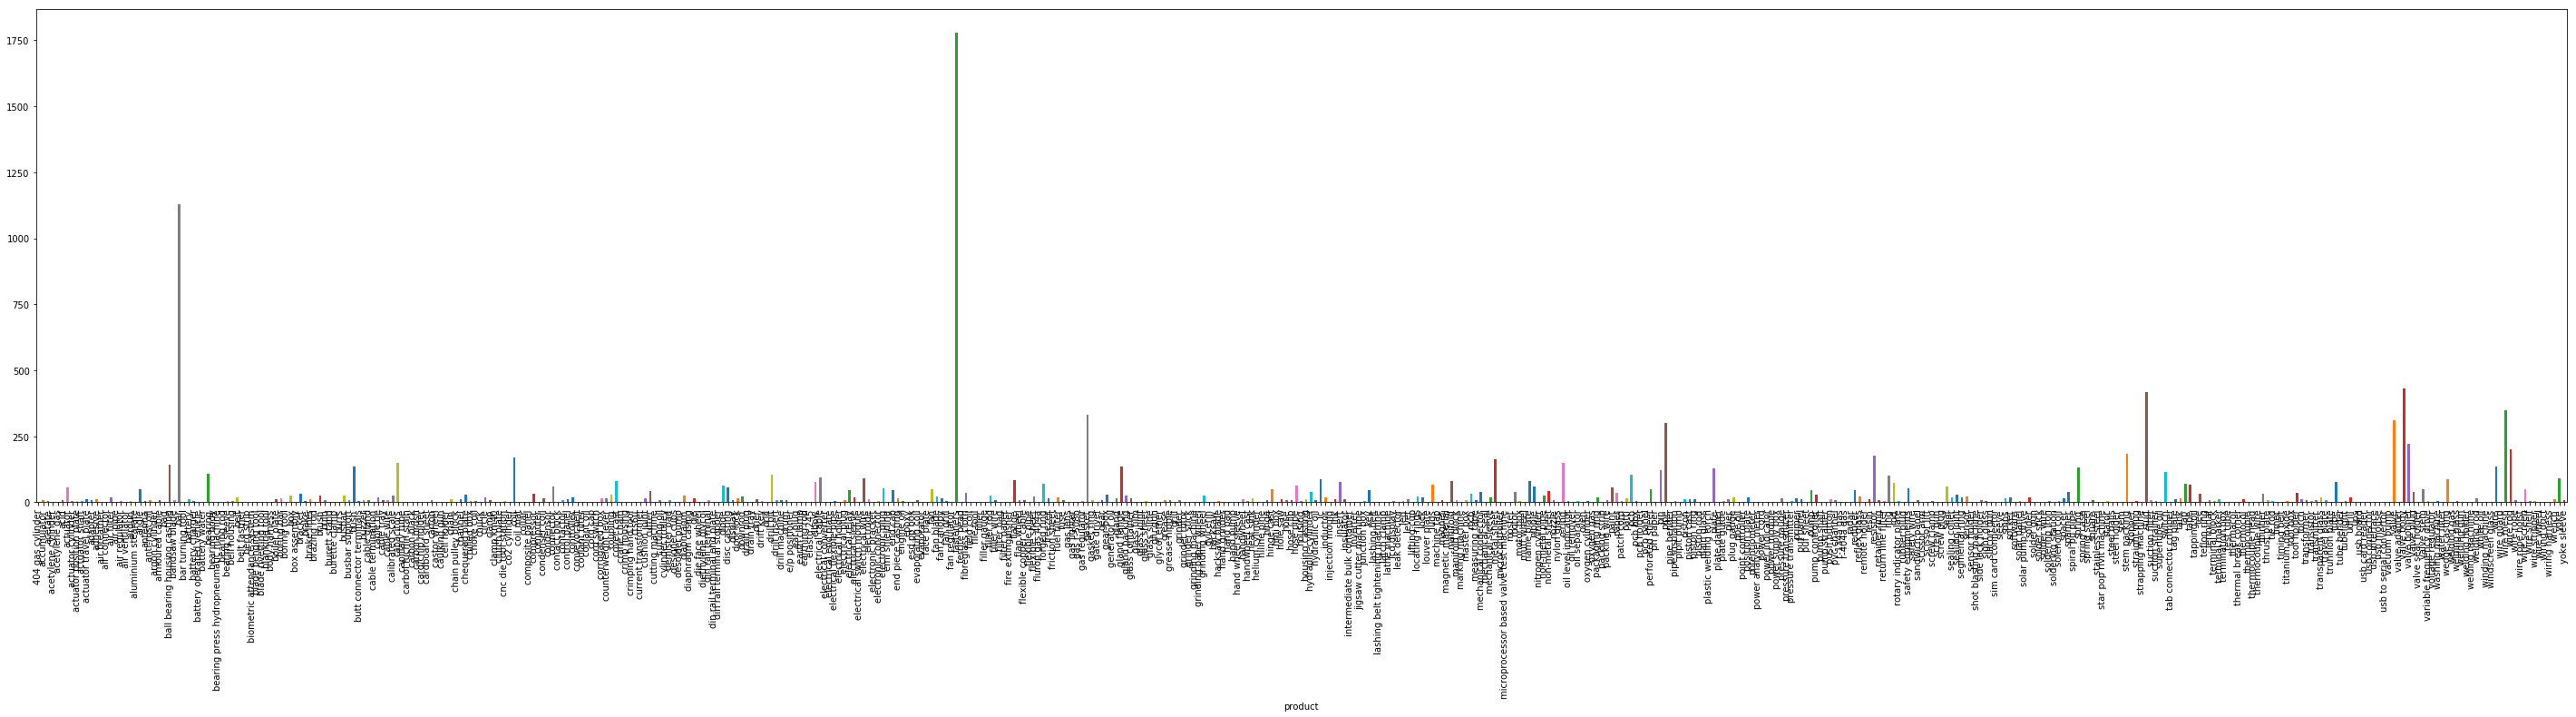

In [8]:
## To show distribution of product category

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(50,10))
print(max(tranzact_data.groupby('product').feature.count()))
tranzact_data.groupby('product').feature.count().plot.bar(ylim=0)
plt.show()

## Pl. note the unbalance distribution of product categories. In category Fasteners, there are 1780 items(maxm no.)

In [9]:
## Gives the product wise item distribution. In some product categories there are only 1 item.
from collections import Counter
Counter(tranzact_data["product"])

Counter({'404 gas cylinder': 1,
         'accumulator': 9,
         'acetate': 4,
         'acetylene cylinder': 2,
         'acetylene gas': 1,
         'acid': 9,
         'actuator': 55,
         'actuator cylinder': 5,
         'actuator position plate': 4,
         'actuator shaft': 5,
         'actuator travel plate': 11,
         'adapter': 7,
         'adhesive': 12,
         'air breather': 2,
         'air connector': 1,
         'air filter': 17,
         'air pipe': 3,
         'air regulator': 6,
         'air ventilator': 1,
         'airgun': 5,
         'aluminium stearate': 1,
         'angle': 48,
         'antenna': 4,
         'anti-rust oil': 7,
         'argon cylinder': 2,
         'armoured cable': 8,
         'bag': 1,
         'ball bearing housing casting': 144,
         'bandsaw blade': 7,
         'bar': 1129,
         'bar turning tool': 2,
         'battery': 13,
         'battery charger': 6,
         'battery operated vehicle': 1,
         'battery wate

In [10]:
## Creating X and y variables for training. X = Items or item 'feature'. y = 'product' or product category

X = []
for i in range(tranzact_data.shape[0]):
    X.append(tranzact_data.iloc[i][1])
y = np.array(tranzact_data["product"])

print(X[1])


accumulator model as connection emerson make


In [11]:
#train test split in 80% / 20% ratio

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

print(X_train[1])
print(y_train[1])

16v zener sod 16v zener power
diode


In [12]:
## Creating the pipeline for learning which include vectorizing and training with 
## Support Vector Classifier with Linear Kernel :

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier


model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))), \
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)), \
                 ('clf', OneVsRestClassifier(LinearSVC(class_weight = 'balanced')))])

In [13]:
#fit model with training data

model.fit(X_train, y_train)

#evaluation on test data

pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score

model_accuracy = accuracy_score(pred, y_test)

print(model_accuracy)


0.9667405764966741


In [29]:
## Input Item name here in the syntax given below :

Input_Item_Name = ['QUAD BAND GSM MODEM IC SIM800C LCC SIMCOM QUAD BAND GSM IC 32M S2-10688-Z1L0X']

In [30]:
## Find product category here :
Output_Product_Category = model.predict(Input_Item_Name)
print('Product Category = ', Output_Product_Category)

Product Category =  ['ic']
